<a href="https://colab.research.google.com/github/reydf/reinforcement-lander/blob/main/RL_Study_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install gym[box2d]
!python -m pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

In [2]:
"""
Implementation of vanilla DQN using OpenAI LunarLander
"""
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import os
os.environ['SDL_VIDEODRIVER']='dummy'
import pygame
pygame.display.set_mode((640,480))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


In [3]:
#Calling the environment. 
env = gym.make('LunarLander-v2', render_mode='human',enable_wind = True)

#Check out the state space
n_obs = len(env.reset())
n_act = env.action_space.n
print('State shape: ', n_obs)#env.observation_space.shape)
print('Number of actions: ', n_act )

# By default, we use CPU. If CUDA is available, this command will automatically call it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


State shape:  8
Number of actions:  4


In [4]:
#Neural Network module to be used for the agent.
class Nets(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(Nets, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # There are four states, so there are four layers.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(x)
        x = F.relu(self.layer2(x))
        x = F.relu(x)
        return self.layer3(x)

In [5]:
#Transition function, for the state, action, next state, and reward.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
    def push(self, *args):
        #Saving a transition
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

In [6]:
#Defining the Agent
class Agent:
    
    def __init__(self, learn_rate, gamma, n_act, epsilon, batch):
        #self.action_space = [i for i in range(n_act)]
        self.gamma = gamma #Discount rate
        self.epsilon = epsilon #episode starts
        self.batch_size = batch #Number of transitions sampled inside the replay buffer
        self.epsilon_decay = 1000 #Episode decay rate
        self.epsilon_final = 0.05 #Episode final rate
        self.update_rate = 0.005
        self.act = n_act
        self.step_counter = 0
        self.learn_rate = learn_rate
        state, _ = env.reset(return_info=True)
        no_obs = len(state)
        self.policy_net = Nets(no_obs, self.act).to(device)
        self.target_net = Nets(no_obs, self.act).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
    memory = ReplayBuffer(10000)   
    steps_done = 0
    def select_policy(self, state):
        #global steps_done
        sample = random.random()
        eps_threshold = self.epsilon_final + (self.epsilon - self.epsilon_final) * \
            math.exp(-1. * self.step_counter / self.epsilon_decay)
        self.step_counter  += 1
        if sample > eps_threshold:
            with torch.no_grad():
            # t.max(1) will return largest column value of each row, to pick the policy with larger expected reward.
                 return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        
        optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.learn_rate, amsgrad=True)
    
        
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                            if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

    # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
        optimizer.zero_grad()
        loss.backward()
    # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        optimizer.step()
    
    episode_durations = []
    def plot_durations(self, show_result=False):
        
        #Showing the real-time plotting of the training.
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            env.close()
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
            plt.xlabel('Episode')
        plt.ylabel('Rewards')
        plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    
    def train (self):
        if torch.cuda.is_available():
            num_episodes = 600
        else:
            num_episodes = 150
        #memory = ReplayBuffer(10000)
        for i_episode in range(num_episodes):
            state, _ = env.reset(return_info=True)
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            env.render()
            
            for t in count():
                action = self.select_policy(state)
                observation, reward, terminated, truncated = env.step(action.item())
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                    
                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)
                
                # Move to the next state
                state = next_state
                #optimize your model
                self.optimize_model()
                
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.update_rate + target_net_state_dict[key]*(1-self.update_rate)
                    self.target_net.load_state_dict(target_net_state_dict)
                    
                if done:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                    break
                
        print('Complete')
        self.plot_durations(show_result=True)
        plt.ioff()
        plt.show()


In [7]:
#Define the needed hyperparameters for training.
batch = 128 #Number of transitions sampled inside the replay buffer
gamma = 0.99 #Discount rate
start_eps = 0.9 #Epsilon starting value
learn_rate = 1e-4 #Learning rate of the neural net

#(self, learn_rate, gamma, n_act, epsilon, batch)
agent_dqn = Agent(learn_rate, gamma, n_act, start_eps, batch)

Complete


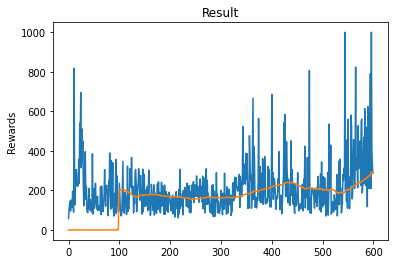

In [8]:
agent_dqn.train()